<a href="https://colab.research.google.com/github/ihuang87/Relative-Belief-Ratio/blob/main/Logistic_Regression_SimEB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import scipy.stats as stats
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import logsumexp
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import time

In [3]:
def binom_log_likelihood(p, y):
  return y * np.log(p) + (1 - y) * np.log(1 - p)

## Hypothesis Bias Against

In [5]:
def hypothesis_bias_against_logistic(
    n_sample,
    X,
    hyp_betas,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    """
    Estimate the bias against a hypothesis in a logistic regression model.

    Parameters:
    ----------
    n_sample : int
        The number of samples per dataset.

    X : ndarray of shape (n_sample, len(hyp_betas))
        The design matrix containing input features for the logistic model.

    hyp_betas : ndarray of shape (len(hyp_betas),)
        The hypothesized logistic regression coefficients.

    prior_mu : ndarray of shape (len(hyp_betas),)
        The mean vector of the prior distribution for the coefficients.

    prior_sigma : ndarray of shape (len(hyp_betas), len(hyp_betas))
        The covariance matrix of the prior distribution for the coefficients.

    n_datasets : int, optional, default=1000
        The number of simulated datasets to generate.

    n_marginal : int, optional, default=1000
        The number of prior samples used to estimate the marginal likelihood.

    cumulative : bool, optional, default=False
        If True, returns the cumulative bias after a "burn-in" period of 300 datasets.
        If False, returns the final bias value after all datasets.

    Returns:
    -------
    float or ndarray
        - If `cumulative` is False, returns a single float representing the final
          bias against the hypothesis after all datasets.
        - If `cumulative` is True, returns a 1D array of cumulative bias values
          (one value for each dataset after the burn-in period).
    """

    bias_against_sums = []

    # Generate data from the hypothesized betas along with the input design matrix
    logits = X @ hyp_betas
    p = np.exp(logits) / (1 + np.exp(logits))
    y = np.random.binomial(1, p = p, size = (n_datasets, n_sample))

    # Compute log-likelihood of y given the hypothesis
    log_likelihood = binom_log_likelihood(p, y)
    total_log_likelihood = log_likelihood.sum(axis=1)

    # Sample for betas from the prior
    betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)
    logits_pri = X @ betas.T
    p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))
    y_repeated = np.repeat(y[:, np.newaxis, :], n_marginal, axis=1)
    y_repeated = y_repeated.transpose(2, 1, 0)

    # Calculate log-likelihood for each y given p, then sum across samples
    log_likelihood = binom_log_likelihood(p_pri[..., np.newaxis], y_repeated)  # Shape: (n_sample, n_marginal, n_datasets)
    log_likelihoods = log_likelihood.sum(axis=0)  # Sum over samples; result shape: (n_marginal, n_datasets)
    # Compute log marginal likelihood across all beta samples
    log_marginal_likelihood = logsumexp(log_likelihoods, axis=0) - np.log(n_marginal)

    # Calculate the bias against
    bias_against = (total_log_likelihood - log_marginal_likelihood) <= 0
    bias_against_sums = (bias_against.cumsum() / np.arange(1, len(bias_against) + 1))

    if cumulative:
        return bias_against_sums[300:]
    else:
        return bias_against_sums[-1]

Define Parameters

In [4]:
# Define parameters for simulations
n_sample = 20  # Number of samples per dataset
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples
prior_mu = np.zeros(2)  # Mean of the prior distribution for betas (2 parameters)
prior_sigma = np.eye(2)  # Covariance of the prior (identity for independent priors)
hyp_betas = np.array([0.0, 0.0])  # Hypothesized logistic regression coefficients
cumulative = True  # Compute cumulative bias against
num_iterations = 5

# Design matrix
X = np.ones((n_sample, len(hyp_betas)))
X[:int(n_sample/2),0] = 0
X[0:-1:2,1] = 0

In [ ]:
n_samples = list(range(10, 100 + 1, 10))
sigmas = [1, 2, 3, 4, 5]
cumulative = False  # Compute final bias against

# Store results
results = {sigma: [] for sigma in sigmas}  # Store bias against for each sigma

# Loop through sigmas and n_samples
for sigma in sigmas:
    for n_sample in n_samples:
        # Create X matrix with size (n_sample, p)
        X = np.ones((n_sample, len(hyp_betas)))
        X[:int(n_sample / 2), 0] = 0
        X[0:-1:2, 1] = 0

        # Call the function
        bias_against = hypothesis_bias_against_logistic(
            n_sample=n_sample,
            X=X,
            hyp_betas=hyp_betas,
            n_datasets=n_datasets,
            n_marginal=n_marginal,
            prior_mu=prior_mu,
            prior_sigma=sigma * np.eye(len(hyp_betas)),
            cumulative=cumulative,
        )
        results[sigma].append(bias_against)

# Plot the results
for sigma, biases in results.items():
    plt.plot(n_samples, biases, label=f"sigma = {sigma}")

# Customize the plot
plt.xlabel("n_sample")
plt.ylabel("Bias Against")
plt.title("Bias Against for Varying Sigma and n_sample")
plt.legend()
plt.show()

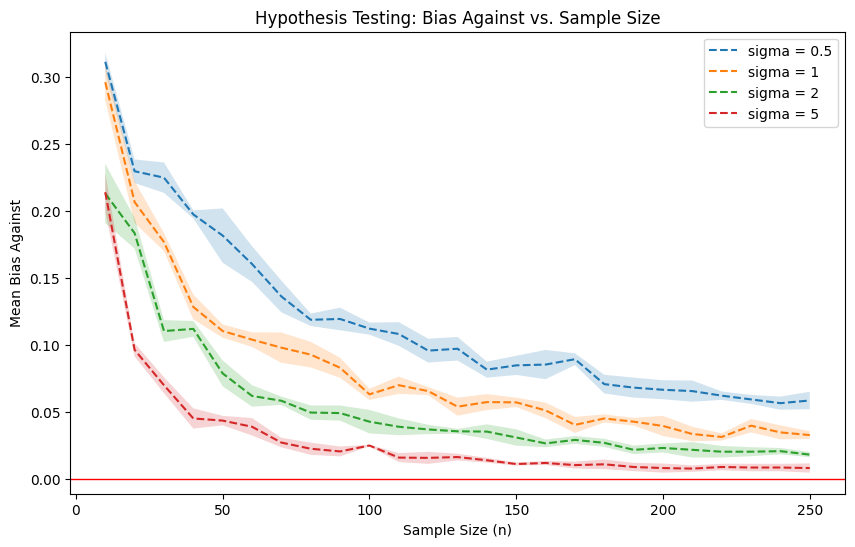

In [8]:
from scipy.stats import norm

# Parameters
n_samples = list(range(10, 250 + 1, 10))  # Sample sizes
sigmas = [0.5, 1, 2, 5]  # Different prior variances
hyp_betas = np.array([0.0, 0.0])  # Hypothesized coefficients
n_datasets = 1000  # Number of datasets
n_marginal = 1000  # Number of marginal samples
prior_mu = np.zeros(len(hyp_betas))  # Prior mean
n_simulations = 5  # Number of simulation runs
cumulative = False  # Whether to calculate cumulative bias

# Store results for multiple simulations
results = {sigma: {n: [] for n in n_samples} for sigma in sigmas}

# Run simulations
for sim in range(n_simulations):
    for sigma in sigmas:
        for n_sample in n_samples:
            # Create X matrix with size (n_sample, p)
            X = np.ones((n_sample, len(hyp_betas)))
            X[:int(n_sample / 2), 0] = 0
            X[0:-1:2, 1] = 0

            # Call the bias calculation function
            bias_against = hypothesis_bias_against_logistic(
                n_sample=n_sample,
                X=X,
                hyp_betas=hyp_betas,
                n_datasets=n_datasets,
                n_marginal=n_marginal,
                prior_mu=prior_mu,
                prior_sigma=sigma * np.eye(len(hyp_betas)),
                cumulative=cumulative,
            )
            results[sigma][n_sample].append(bias_against)

# Calculate mean and confidence interval
mean_results = {sigma: [] for sigma in sigmas}
conf_intervals = {sigma: [] for sigma in sigmas}

for sigma in sigmas:
    for n_sample in n_samples:
        biases = results[sigma][n_sample]
        mean_bias = np.mean(biases)
        std_error = np.std(biases) / np.sqrt(n_simulations)  # Standard error
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        conf_interval = z_score * std_error

        mean_results[sigma].append(mean_bias)
        conf_intervals[sigma].append(conf_interval)

# Plot results with confidence interval shading
plt.figure(figsize=(10, 6))
for sigma in sigmas:
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c for m, c in zip(mean_bias, conf_interval)]

    # Plot the mean line
    plt.plot(n_samples, mean_bias, linestyle='--', label=f"sigma = {sigma}")

    # Fill the confidence interval
    plt.fill_between(
        n_samples,
        lower_bound,
        upper_bound,
        alpha=0.2,
    )

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linewidth=1)

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Mean Bias Against")
plt.title("Hypothesis Testing: Bias Against vs. Sample Size")
plt.legend()
plt.show()

## Estimation Bias Against

In [6]:
def estimation_bias_against_logistic(
    X,
    n_sample,
    n_param,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    """
    Compute the bias against a logistic regression coefficients in hypothesis testing.

    Parameters
    ----------
    X : ndarray of shape (n_datasets, n_sample, n_param)
        The design matrix containing input features for the logistic model. Each dataset
        has `n_sample` samples and `n_param` features.

    n_sample : int
        The number of samples per dataset.

    n_param : int
        The number of parameters (features) in the logistic regression model.

    prior_mu : ndarray of shape (n_param,)
        The mean vector of the prior distribution for the regression coefficients.

    prior_sigma : ndarray of shape (n_param, n_param)
        The covariance matrix of the prior distribution for the regression coefficients.

    n_datasets : int, optional, default=1000
        The number of datasets to simulate.

    n_marginal : int, optional, default=1000
        The number of prior samples used for estimating the marginal likelihood.

    cumulative : bool, optional, default=False
        If True, returns the cumulative bias after a burn-in period of 300 datasets.
        If False, returns the final bias value after all datasets.

    Returns
    -------
    float or ndarray
        - If `cumulative` is False, returns a single float representing the final bias
          against the hypothesis.
        - If `cumulative` is True, returns a 1D array of cumulative bias values, one
          value for each dataset after the burn-in period.
    """

    # Generate the true coefficients for each dataset
    true_betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_datasets)

    # Generate sampled coefficients for estimating marginal likelihood
    betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)

    bias_against_sums = []

     # Generate data based on the true coeff above
    logits = np.einsum('ijk,ik->ij', X, true_betas)
    p = np.exp(logits) / (1 + np.exp(logits))
    y = np.random.binomial(1, p = p)

    # Compute log_likelihood of the data
    log_likelihood = binom_log_likelihood(p, y)
    log_likelihoods = log_likelihood.sum(axis=1)

    # Compute marginal log likelihood
    X_repeated = np.repeat(X[:, np.newaxis, :, :], n_marginal, axis=1)  # Shape: (n_datasets, n_marginal, n_sample, n_param)
    logits_pri = np.einsum('dmsp,mp->dms', X_repeated, betas)
    p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))

    total_log_likelihood = np.zeros((n_datasets, n_marginal))
    for j in range(n_marginal):
        # Compute log-likelihood for all datasets for marginal j
        log_likelihood = y * np.log(p_pri[:, j, :]) + (1 - y) * np.log(1 - p_pri[:, j, :])
        total_log_likelihood[:, j] = log_likelihood.sum(axis=1)

    marginal_log_likelihood = logsumexp(total_log_likelihood, axis=1) - np.log(n_marginal)

    bias_against = (log_likelihoods - marginal_log_likelihood) <= 0

        # Compute the cumulative bias against (running mean of bias indicators)
    bias_against_sums = bias_against.cumsum() / np.arange(1, len(bias_against) + 1)

    # Return cumulative bias after burn-in (if cumulative=True), or the final bias value
    if cumulative:
        return bias_against_sums[300:]  # Return cumulative bias after burn-in period
    else:
        return bias_against_sums[-1]  # Return final bias in favor value

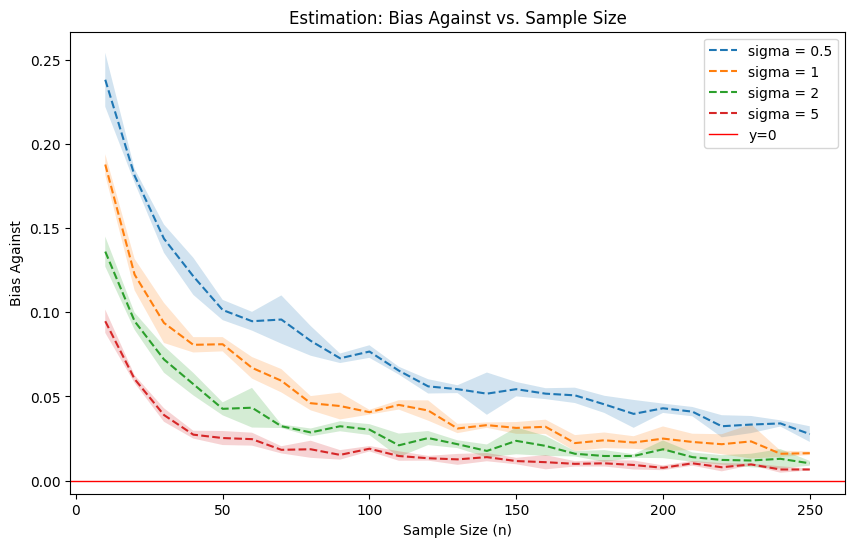

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Define parameters
n_loops = 3  # Number of simulation loops
n_samples = list(range(10, 250 + 1, 10))  # Varying sample sizes
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of samples for marginal likelihood estimation
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
sigmas = [0.5, 1, 2, 5]  # Different sigma values
cumulative = False  # Compute final bias against

# Store results for multiple loops
results = {sigma: {n: [] for n in n_samples} for sigma in sigmas}

# Run simulations for multiple loops
for sim in range(n_loops):
    for sigma in sigmas:
        for n_sample in n_samples:
            # Generate synthetic design matrix X for current sample size
            X = np.ones((n_sample, n_param))
            X[:int(n_sample / 2), 0] = 0
            X[0:-1:2, 1] = 0
            X = np.tile(X, (n_datasets, 1, 1))  # Replicate for all datasets

            # Call the function
            bias_against_result = estimation_bias_against_logistic(
                X=X,
                n_sample=n_sample,
                n_param=n_param,
                prior_mu=prior_mu,
                prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance by sigma
                n_datasets=n_datasets,
                n_marginal=n_marginal,
                cumulative=cumulative,
            )

            # Store the result for this loop
            results[sigma][n_sample].append(np.mean(bias_against_result))

# Calculate mean and confidence intervals
mean_results = {sigma: [] for sigma in sigmas}
conf_intervals = {sigma: [] for sigma in sigmas}

for sigma in sigmas:
    for n_sample in n_samples:
        biases = results[sigma][n_sample]
        mean_bias = np.mean(biases)
        std_error = np.std(biases) / np.sqrt(n_loops)  # Standard error
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        conf_interval = z_score * std_error

        mean_results[sigma].append(mean_bias)
        conf_intervals[sigma].append(conf_interval)

# Plot results with confidence interval shading
plt.figure(figsize=(10, 6))
for sigma in sigmas:
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c for m, c in zip(mean_bias, conf_interval)]

    # Plot the mean line
    plt.plot(n_samples, mean_bias, linestyle='--', label=f"sigma = {sigma}")

    # Fill the confidence interval
    plt.fill_between(
        n_samples,
        lower_bound,
        upper_bound,
        alpha=0.2,
    )

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linewidth=1, label="y=0")

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias Against")
plt.title("Estimation: Bias Against vs. Sample Size")
plt.legend()
plt.show()


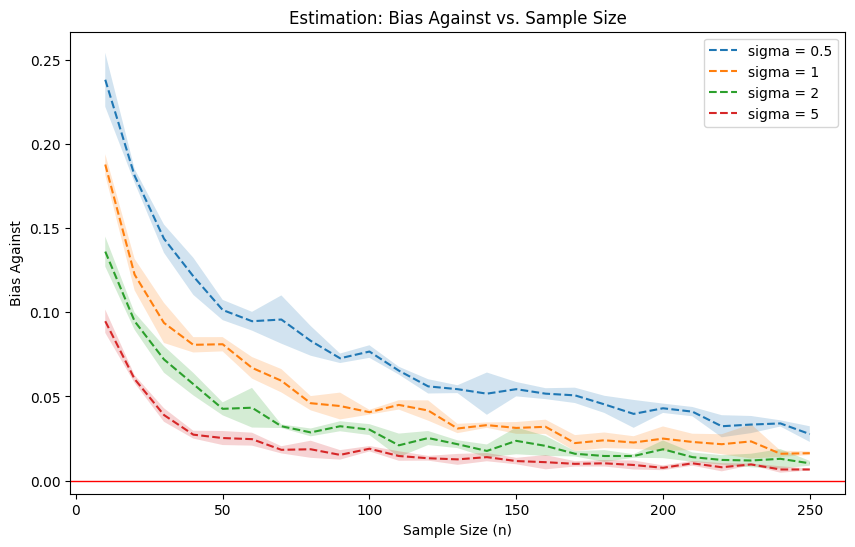

In [11]:
plt.figure(figsize=(10, 6))
for sigma in sigmas:
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c for m, c in zip(mean_bias, conf_interval)]

    # Plot the mean line
    plt.plot(n_samples, mean_bias, linestyle='--', label=f"sigma = {sigma}")

    # Fill the confidence interval
    plt.fill_between(
        n_samples,
        lower_bound,
        upper_bound,
        alpha=0.2,
    )

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linewidth=1)

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias Against")
plt.title("Estimation: Bias Against vs. Sample Size")
plt.legend()
plt.show()

## Hypothesis Bias in Favour



In [7]:
def hypothesis_bias_in_favour_logistic(
    n_sample,
    X,
    hyp_betas,
    delta,
    prior_mu,
    prior_sigma,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    """
    Compute the bias in favor of a logistic regression.

    Parameters
    ----------
    n_sample : int
        Number of samples per dataset.

    X : ndarray of shape (n_sample, n_features)
        Design matrix containing input features for the logistic regression model.

    hyp_betas : ndarray of shape (n_features,)
        The hypothesized logistic regression coefficients.

    delta : float
        The amount of perturbation applied to each coefficient to create alternative hypotheses.

    prior_mu : ndarray of shape (n_features,)
        Mean vector of the prior distribution for regression coefficients.

    prior_sigma : ndarray of shape (n_features, n_features)
        Covariance matrix of the prior distribution for regression coefficients.

    n_datasets : int, optional, default=1000
        Number of datasets to simulate.

    n_marginal : int, optional, default=1000
        Number of prior samples used to estimate the marginal likelihood.

    cumulative : bool, optional, default=False
        Whether to return cumulative bias values after a burn-in period.
        If False, returns only the final bias value.

    Returns
    -------
    ndarray or float
        - If `cumulative=True`, returns a 1D array of cumulative bias values after the burn-in period.
        - If `cumulative=False`, returns a single float representing the final bias in favor.
    """

    bias_in_fav_sums = []
    sampled_betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)

    for i in range(len(hyp_betas)):
        for shift in [+delta, -delta]:
          shifted_betas = hyp_betas.copy()
          shifted_betas[i] += shift  # Shift only the i-th parameter

    # Generate data from with true shifted betas and the input design matrix
          true_logits = X @ shifted_betas
          true_p = np.exp(true_logits) / (1 + np.exp(true_logits))
          y = np.random.binomial(1, p = true_p, size = (n_datasets, n_sample))

    # Calculate logits and probabilities based on hyp_betas(not true)
          logits = X @ hyp_betas
          p = np.exp(logits) / (1 + np.exp(logits))

    # Compute log-likelihood of y given the hypothesis
          log_likelihood = binom_log_likelihood(p, y)
          total_log_likelihood = log_likelihood.sum(axis=1)

          # betas from the prior
          logits_pri = X @ sampled_betas.T
          p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))
          y_repeated = np.repeat(y[:, np.newaxis, :], n_marginal, axis=1)
          y_repeated = y_repeated.transpose(2, 1, 0)

          # Calculate log-likelihood for each y given p, then sum across samples
          log_likelihood = binom_log_likelihood(p_pri[..., np.newaxis], y_repeated)  # Shape: (n_sample, n_marginal, n_datasets)
          log_likelihoods = log_likelihood.sum(axis=0)  # Sum over samples; result shape: (n_marginal, n_datasets)
          # Compute log marginal likelihood across all beta samples
          log_marginal_likelihood = logsumexp(log_likelihoods, axis=0) - np.log(n_marginal)

    # Calculate the bias against
          bias_in_fav = (total_log_likelihood - log_marginal_likelihood) > 0
          bias_in_fav_sum = bias_in_fav.cumsum() / np.arange(1, len(bias_in_fav) + 1)
          bias_in_fav_sums.append(bias_in_fav_sum)
    # print(np.mean(bias_in_fav))

    final_bias_sums = max(bias_in_fav_sums, key=lambda x: x[-1])
    # print(len(bias_in_fav_sums))

    if cumulative:
        return final_bias_sums[200:]
    else:
        return final_bias_sums[-1]

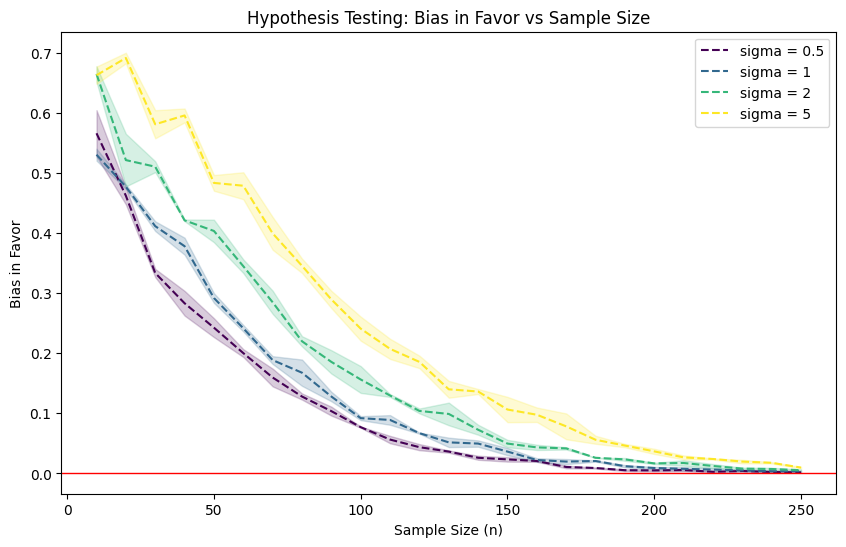

In [13]:
# Define parameters
n_loops = 3  # Number of simulation loops
n_samples = list(range(10, 250 + 1, 10))  # Sample sizes
n_param = 2  # Number of parameters (features) in the logistic model
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
delta = 1  # Perturbation for hypothesis testing
sigmas = [0.5, 1, 2, 5]  # Varying sigma values
hyp_betas = np.array([0.0, 0.0])  # Hypothesized coefficients
prior_mu = np.zeros(n_param)  # Prior mean

# Store results for each sigma
results = {sigma: {n: [] for n in n_samples} for sigma in sigmas}

# Run simulations for multiple loops
for sim in range(n_loops):
    for sigma in sigmas:
        for n_sample in n_samples:
            # Generate a synthetic design matrix X
            X = np.ones((n_sample, len(hyp_betas)))
            X[:int(n_sample / 2), 0] = 0
            X[0:-1:2, 1] = 0

            # Call the function
            try:
                bias_in_favour = hypothesis_bias_in_favour_logistic(
                    n_sample=n_sample,
                    X=X,
                    hyp_betas=hyp_betas,
                    delta=delta,
                    prior_mu=prior_mu,
                    prior_sigma=sigma * np.eye(n_param),  # Scale prior covariance by sigma
                    n_datasets=n_datasets,
                    n_marginal=n_marginal,
                    cumulative=True,
                )

                # Store the final bias (last cumulative value)
                results[sigma][n_sample].append(bias_in_favour[-1])
            except Exception as e:
                print(f"Error for sigma={sigma}, n_sample={n_sample}: {e}")
                results[sigma][n_sample].append(None)

# Calculate mean and confidence intervals
mean_results = {sigma: [] for sigma in sigmas}
conf_intervals = {sigma: [] for sigma in sigmas}

for sigma in sigmas:
    for n_sample in n_samples:
        biases = [b for b in results[sigma][n_sample] if b is not None]  # Remove None values
        mean_bias = np.mean(biases) if biases else None
        std_error = np.std(biases) / np.sqrt(n_loops) if biases else None  # Standard error
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        conf_interval = z_score * std_error if biases else None

        mean_results[sigma].append(mean_bias)
        conf_intervals[sigma].append(conf_interval)

# Plot results with confidence interval shading
plt.figure(figsize=(10, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sigmas)))  # Generate distinct colors

for idx, sigma in enumerate(sigmas):
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c if m is not None and c is not None else None for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c if m is not None and c is not None else None for m, c in zip(mean_bias, conf_interval)]

    # Clean None values for plotting
    valid_indices = [i for i, m in enumerate(mean_bias) if m is not None]
    valid_n_samples = [n_samples[i] for i in valid_indices]
    valid_mean_bias = [mean_bias[i] for i in valid_indices]
    valid_lower_bound = [lower_bound[i] for i in valid_indices]
    valid_upper_bound = [upper_bound[i] for i in valid_indices]

    # Plot the mean line
    plt.plot(valid_n_samples, valid_mean_bias, linestyle='--', label=f"sigma = {sigma}", color=colors[idx])

    # Fill the confidence interval
    plt.fill_between(
        valid_n_samples,
        valid_lower_bound,
        valid_upper_bound,
        alpha=0.2,
        color=colors[idx],
    )

# Add a red horizontal line at y=0
plt.axhline(y=0, color='red', linewidth=1)

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias in Favor")
plt.title("Hypothesis Testing: Bias in Favor vs Sample Size")
plt.legend()
plt.show()


## Estimation Bias in Favour

In [8]:
def estimation_bias_in_favour_logistic(
    n_sample,
    X,
    n_param,
    delta,
    prior_mu,
    prior_sigma,
    n_iter = 60,
    n_datasets = 1000,
    n_marginal = 1000,
    cumulative = False
):
    beta_0_samples = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_iter)
    sampled_betas = multivariate_normal.rvs(mean=prior_mu, cov=prior_sigma, size=n_marginal)

    max_biases = np.zeros(n_iter)

    for i, beta in enumerate(beta_0_samples):
        # Array to store biases for theta = theta_0 + delta and theta_0 - delta
        biases = []
        for j in range(len(beta)):
              for shift in [+delta, -delta]:
                shifted_betas = beta.copy()
                shifted_betas[j] += shift  # Shift only the i-th parameter
                # print(shifted_betas)

          # Generate data from the hypothesized betas along with the input design matrix
                true_logits = X @ shifted_betas
                true_p = np.exp(true_logits) / (1 + np.exp(true_logits))
                y = np.random.binomial(1, p = true_p, size = (n_datasets, n_sample))

          # Calculate true logits and probabilities based on hyp_betas
                logits = X @ beta
                p = np.exp(logits) / (1 + np.exp(logits))

          # Compute log-likelihood of y given the hypothesis
                log_likelihood = binom_log_likelihood(p, y)
                total_log_likelihood = log_likelihood.sum(axis=1)

                logits_pri = X @ sampled_betas.T
                p_pri = np.exp(logits_pri) / (1 + np.exp(logits_pri))
                y_repeated = np.repeat(y[:, np.newaxis, :], n_marginal, axis=1)
                y_repeated = y_repeated.transpose(2, 1, 0)

                # Calculate log-likelihood for each y given p, then sum across samples
                log_likelihood = binom_log_likelihood(p_pri[..., np.newaxis], y_repeated)  # Shape: (n_sample, n_marginal, n_datasets)
                log_likelihoods = log_likelihood.sum(axis=0)  # Sum over samples; result shape: (n_marginal, n_datasets)
                # Compute log marginal likelihood across all beta samples
                log_marginal_likelihood = logsumexp(log_likelihoods, axis=0) - np.log(n_marginal)

                biases_in_fav = np.array([(total_log_likelihood - log_marginal_likelihood) > 0])

                final_bias = biases_in_fav.mean()

                # Store the bias for this delta sign
                biases.append(final_bias)

              max_biases[i] = max(biases)

    bias_in_favor_estimate = max_biases.mean()

        # Return cumulative bias if `cumulative=True`, otherwise return the final bias value
    if cumulative:
        return max_biases.cumsum() / np.arange(1, len(max_biases) + 1)  # Return cumulative bias after burn-in
    else:
        return bias_in_favor_estimate  # Return final bias in favor value

In [ ]:
# Define parameters
n_loops = 3  # Number of simulation loops for averaging
n_samples = list(range(10, 200 + 1, 10))  # Different sample sizes to vary
n_param = 2  # Number of parameters (features) in the logistic model
n_iter = 50  # Number of iterations (beta samples)
delta = 1  # Perturbation amount
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas
sigmas = [0.01, 0.1]  # Varying sigma values
n_datasets = 1000  # Number of datasets to simulate
n_marginal = 1000  # Number of prior samples for marginal likelihood
cumulative = False  # Return final bias estimate for each sample size

# Store results for each sigma
results = {sigma: {n_sample: [] for n_sample in n_samples} for sigma in sigmas}

# Run simulations for multiple loops
for sim in range(n_loops):
    for sigma in sigmas:
        for n_sample in n_samples:
            # Generate a synthetic design matrix X for the current sample size
            X = np.random.randn(n_sample, n_param)  # Random design matrix
            prior_sigma = sigma * np.eye(n_param)  # Scale covariance by sigma

            # Call the function with the current sample size and sigma
            bias_estimate = estimation_bias_in_favour_logistic(
                n_sample=n_sample,
                X=X,
                n_param=n_param,
                n_iter=n_iter,
                delta=delta,
                prior_mu=prior_mu,
                prior_sigma=prior_sigma,
                n_datasets=n_datasets,
                n_marginal=n_marginal,
                cumulative=cumulative,
            )
            results[sigma][n_sample].append(bias_estimate)

# Calculate mean and confidence intervals
mean_results = {sigma: [] for sigma in sigmas}
conf_intervals = {sigma: [] for sigma in sigmas}

for sigma in sigmas:
    for n_sample in n_samples:
        biases = results[sigma][n_sample]
        mean_value = np.mean(biases)
        std_error = np.std(biases) / np.sqrt(n_loops)  # Standard error
        z_score = norm.ppf(0.975)  # For 95% confidence interval
        conf_interval = z_score * std_error

        mean_results[sigma].append(mean_value)
        conf_intervals[sigma].append(conf_interval)

# Plot results with confidence intervals for each sigma
plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(sigmas)))  # Generate distinct colors

for idx, sigma in enumerate(sigmas):
    mean_bias = mean_results[sigma]
    conf_interval = conf_intervals[sigma]
    lower_bound = [m - c for m, c in zip(mean_bias, conf_interval)]
    upper_bound = [m + c for m, c in zip(mean_bias, conf_interval)]

    # Plot the mean line
    plt.plot(n_samples, mean_bias, linestyle = "--", label=f"sigma = {sigma}", color=colors[idx])

    # Fill the confidence interval
    plt.fill_between(
        n_samples,
        lower_bound,
        upper_bound,
        alpha=0.2,
        color=colors[idx],
    )

# Customize the plot
plt.xlabel("Sample Size (n)")
plt.ylabel("Bias in Favour")
plt.title("Estimation: Bias in Favour vs Sample Size")
plt.axhline(y=0, color='red', linewidth=1)
plt.legend()
plt.show()


## Runtime

In [26]:
print(runtimes)
r = runtimes.copy()
print(r)

{'Hypothesis Bias in Favour Logistic': 7.213987350463867, 'Estimation Bias in Favour Logistic': 434.69376239776614}
{'Hypothesis Bias in Favour Logistic': 7.213987350463867, 'Estimation Bias in Favour Logistic': 434.69376239776614}


In [32]:
print(runtimes_1)
combined_runtime = {**runtimes, **runtimes_1}
print(combined_runtime)

{'Hypothesis Bias Against Logistic': 1.8548819541931152}
{'Hypothesis Bias in Favour Logistic': 7.213987350463867, 'Estimation Bias in Favour Logistic': 434.69376239776614, 'Hypothesis Bias Against Logistic': 1.8548819541931152}


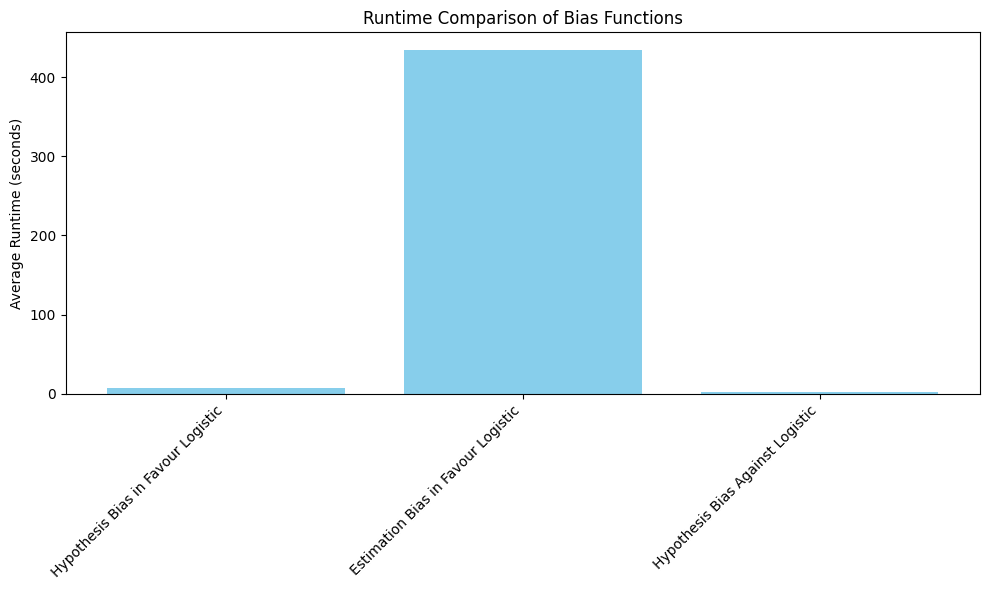

In [34]:
# Plot results
plt.figure(figsize=(10, 6))
plt.bar(combined_runtime.keys(), combined_runtime.values(), color='skyblue')
plt.ylabel("Average Runtime (seconds)")
plt.title("Runtime Comparison of Bias Functions")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

## New Runtime

In [12]:
# Defining the parameters
n_sample = 100

X = np.ones((n_sample, 2))  # Dummy design matrix
X[:int(n_sample / 2), 0] = 0
X[0:-1:2, 1] = 0
n_param = 2

hyp_betas = np.array([0.0, 0.0])
prior_mu = np.zeros(n_param)  # Mean of the prior distribution for betas (2 parameters)
prior_sigma = np.eye(2)

n_datasets_values = [100, 500, 1000, 1500, 2000]  # Varying number of datasets
n_trials = 5  # Number of trials for averaging runtime

delta = 1

cumulative = True

100
500
1000
2000


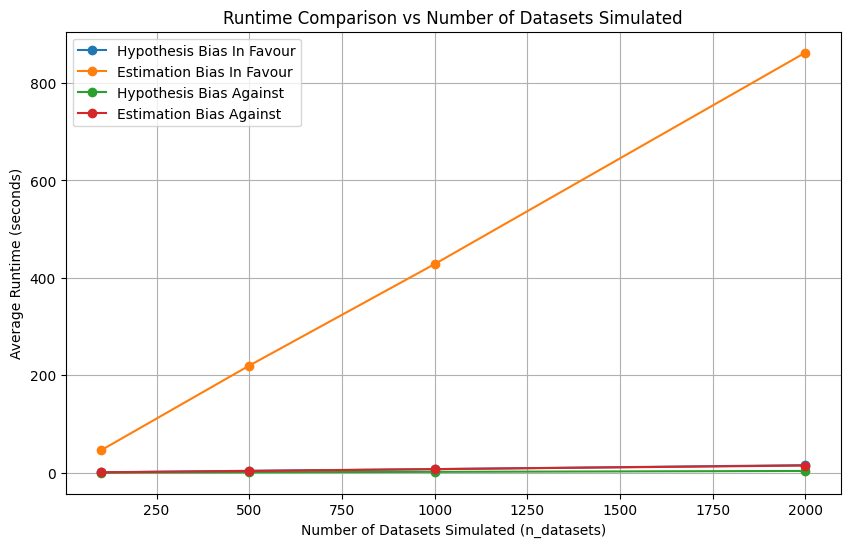

In [13]:
# Parameters
n_datasets_values = [100, 500, 1000, 2000]  # Varying number of datasets
n_trials = 3  # Number of trials for averaging runtime
n_sample = 100
n_iter = 60

X = np.ones((n_sample, 2))  # Dummy design matrix
X[:int(n_sample / 2), 0] = 0
X[0:-1:2, 1] = 0

X_ = np.ones((n_sample, n_param))
X_[:int(n_sample / 2), 0] = 0
X_[0:-1:2, 1] = 0

delta = 1
n_marginal = 1000
n_param = 2
prior_mu = np.zeros(n_param)
prior_sigma = np.eye(n_param)
hyp_betas = np.array([0.0, 0.0])
cumulative = False

# Define functions to compare
functions = {
    "Hypothesis Bias In Favour": hypothesis_bias_in_favour_logistic,
    "Estimation Bias In Favour": estimation_bias_in_favour_logistic,
    "Hypothesis Bias Against": hypothesis_bias_against_logistic,
    "Estimation Bias Against": estimation_bias_against_logistic,
}

# Store runtimes
runtimes = {name: [] for name in functions}

# Measure runtime for each function and n_datasets
for n_datasets in n_datasets_values:
    print(n_datasets)
    for name, func in functions.items():
        times = []
        for _ in range(n_trials):
            start_time = time.time()
            if name == "Hypothesis Bias In Favour":
                func(
                    n_sample=n_sample,
                    X=X,
                    hyp_betas=hyp_betas,
                    delta=delta,
                    prior_mu=prior_mu,
                    prior_sigma=np.eye(n_param),
                    n_datasets=n_datasets,
                    n_marginal=n_marginal,
                    cumulative=cumulative,
                )
            elif name == "Estimation Bias In Favour":
                func(n_sample, X=X, n_param=n_param, n_iter=n_iter, delta=delta, prior_mu=prior_mu, prior_sigma=prior_sigma, n_datasets=n_datasets, n_marginal=n_marginal, cumulative=cumulative)
            elif name == "Hypothesis Bias Against":
                func(n_sample=n_sample, X=X, hyp_betas=hyp_betas, n_datasets=n_datasets, n_marginal=n_marginal, prior_mu=prior_mu, prior_sigma=np.eye(len(hyp_betas)), cumulative=cumulative)
            elif name == "Estimation Bias Against":
                X_ = np.tile(X, (n_datasets, 1, 1))
                func(X=X_,
        n_sample=n_sample,
        n_param=n_param,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=n_datasets,
        n_marginal=n_marginal,
        cumulative=cumulative)
            end_time = time.time()
            times.append(end_time - start_time)
        runtimes[name].append(np.mean(times))

# Plot results
plt.figure(figsize=(10, 6))
for name, runtime in runtimes.items():
    plt.plot(n_datasets_values, runtime, marker='o', label=name)

# Customize plot
plt.xlabel("Number of Datasets Simulated (n_datasets)")
plt.ylabel("Average Runtime (seconds)")
plt.title("Runtime Comparison vs Number of Datasets Simulated")
plt.legend()
plt.grid(True)
plt.show()


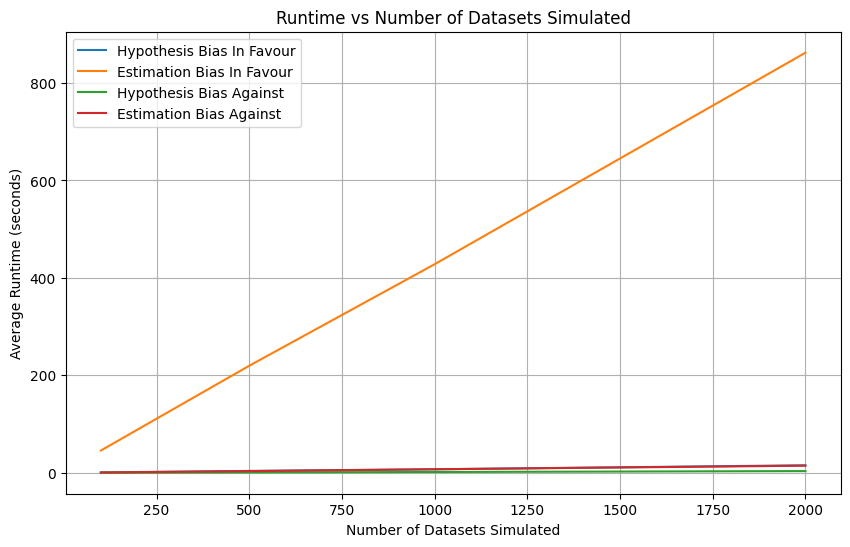

In [17]:
plt.figure(figsize=(10, 6))
for name, runtime in runtimes.items():
    plt.plot(n_datasets_values, runtime, label=name)

# Customize plot
plt.xlabel("Number of Datasets Simulated")
plt.ylabel("Average Runtime (seconds)")
plt.title("Runtime vs Number of Datasets Simulated")
plt.legend()
plt.grid(True)
plt.show()

In [35]:
X_ = np.ones((n_sample, n_param))
X_[:int(n_sample / 2), 0] = 0
X_[0:-1:2, 1] = 0
X_ = np.tile(X, (n_datasets, 1, 1))

estimation_bias_against_logistic(X=X_,
        n_sample=n_sample,
        n_param=n_param,
        prior_mu=prior_mu,
        prior_sigma=prior_sigma,
        n_datasets=500,
        n_marginal=n_marginal,
        cumulative=cumulative)

0.04